# Lesson 3 - IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
torch.cuda.set_device(0)

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [4]:
path = untar_data(URLs.IMDB_SAMPLE)

In [5]:
path.ls()

[PosixPath('/home/cedric/.fastai/data/imdb_sample/tmp'),
 PosixPath('/home/cedric/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [6]:
df = pd.read_csv(path / 'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [7]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [8]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [9]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [10]:
data = TextDataBunch.load(path)

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [11]:
data = TextClasDataBunch.load(path)

In [12]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj",negative
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject ,",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk , """,positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n\n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance of love",negative


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [13]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [14]:
data.train_ds[0][0]

Text xxbos i was not expecting much going in to this , but still came away disappointed . xxmaj this was my least favorite xxmaj xxunk production i have seen . i thought it was supposed to be a comedy , but i only xxunk at 3 or 4 jokes . xxmaj is it really a funny gag to see a fat guy eating xxunk and falling down over and over ? xxmaj what was up with the xxunk in xxmaj heaven scene ? xxmaj fred xxmaj xxunk has been hilarious with some of his xxmaj christopher xxmaj xxunk xxunk , but this did not work . xxmaj they must have spent all the budget on getting " known " actors to appear in this because there was no lighting budget . xxmaj it looked like it was filmed with a video camera and most scenes were very dark . xxmaj does it really take that much film to show someone actually shoot and make a basket , as opposed to cutting away and editing a ball xxunk through a basket ? i try not to be too critical of low budget comedies , but if you want to see something funny go to a real xxmaj 

But the underlying data is all numbers

In [15]:
data.train_ds[0][0].data[:10]

array([   2,   18,   24,   38, 1043,   99,  171,   17,   14,   20])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [16]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [17]:
bs = 48

Now let's grab the full dataset for what follows.

In [18]:
path = untar_data(URLs.IMDB)

In [19]:
path.ls()

[PosixPath('/home/cedric/.fastai/data/imdb/models'),
 PosixPath('/home/cedric/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/cedric/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/cedric/.fastai/data/imdb/unsup'),
 PosixPath('/home/cedric/.fastai/data/imdb/test'),
 PosixPath('/home/cedric/.fastai/data/imdb/README'),
 PosixPath('/home/cedric/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/cedric/.fastai/data/imdb/train')]

In [20]:
(path / 'train').ls()

[PosixPath('/home/cedric/.fastai/data/imdb/train/pos'),
 PosixPath('/home/cedric/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/cedric/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/cedric/.fastai/data/imdb/train/unsup'),
 PosixPath('/home/cedric/.fastai/data/imdb/train/neg')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the review lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [21]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test'])
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

In [22]:
data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [20]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [21]:
data_lm.show_batch()

idx,text
0,"xxbos i heard legends about this "" film "" ( quotes used so as not to insult films ) for a while , so when i finally got the xxup dvd with it , i impatiently started watching it . xxmaj by the end , i * had * to fast forward through just a few of the most moronic , ineptly made , nonsensical scenes of this pointless childish"
1,"all story lines in the first half ... and spews them back out in a sort of redemptive , xxunk , the world is a big coincidence kind of way . xxmaj and it is in fact one of the worst ways to do it . \n\n xxmaj take 1999 's xxmaj magnolia . xxmaj people were n't conveniently tied together over and over again . xxmaj they were just"
2,"xxmaj he eventually tries to kill both of them , and gets stabbed by a warrior after he kills yet another of the tribesmen by ' accident ' . xxmaj the two protagonists get in the plane and fly away , and the woman makes dreamy comments about how when she gets back to civilization she immediately wants to buy a hat . a hat ! ? xxmaj gimme a"
3,"certainly a modern xxmaj american classic . \n\n xxmaj remakes of older movies and the like are sometimes poorly done , but this is probably one case where a creative and inspired director could make a very stunning , memorable , and critically acclaimed production . i do n't ever see that happening since a remake would have to be just as long ( 15 hours ) or longer to"
4,"the xxmaj toronto xxmaj international xxmaj film xxmaj festival and taking only 45 days to shoot , and having only five actors in the play ( the rest were all first time real actors ) . xxmaj arriving home i realized two things from the movie - that there is always a human connection between any one of us despite our differences and secondly , as the director had put"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [22]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


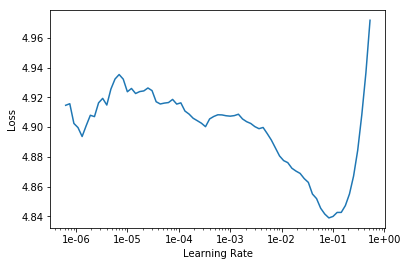

In [27]:
learn.recorder.plot(skip_end=15)

In [39]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,4.209179,4.067793,0.292640


In [40]:
learn.save('fit_head')

In [23]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

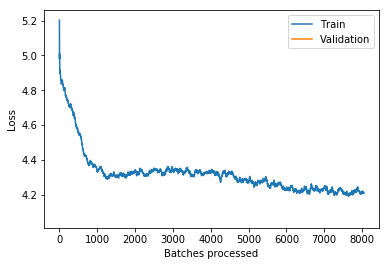

In [43]:
learn.recorder.plot_losses()

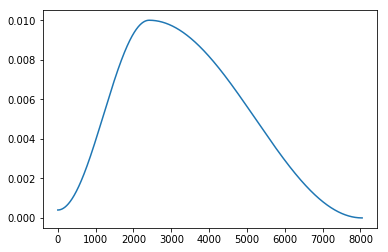

In [44]:
learn.recorder.plot_lr()

In [24]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,3.968855,3.918604,0.306633
2,3.911300,3.850616,0.314884
3,3.879765,3.804880,0.321303
4,3.837026,3.772917,0.325691
5,3.763711,3.748841,0.328365
6,3.731284,3.726021,0.330732
7,3.715182,3.710017,0.332476
8,3.678754,3.697250,0.333901
9,3.642827,3.684941,0.335270
10,3.572811,3.675952,0.336170


KeyboardInterrupt: 

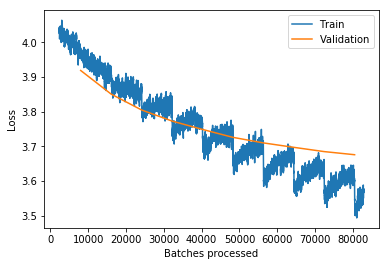

In [47]:
learn.recorder.plot_losses()

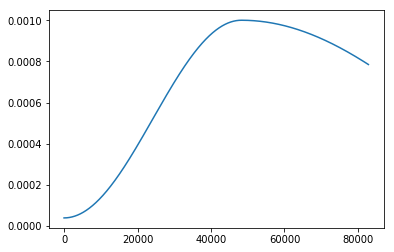

In [48]:
learn.recorder.plot_lr()

In [49]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [25]:
learn.load('fine_tuned');

In [26]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [27]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because jefferey minute reflexivity impenetrably cahill consciences sparseness anxiety puo hulkamania delegates flushing bagpipe rfd adoptive coheres dostoyevsky tensity manners cavalrymen autographs maximilian translucent accusation pevney misconceived zoom gazecki people(including spoliers catalan altar deoxys sudbury fliers s.o.s outshone suns punctuates csi
i liked this movie because perine trauma ultraviolent craving champlain contemplation halmi competently quarter thunderstorm brewer scruffy subdivision prestigious compassionately nukie wass ships confucius haruhiko crutches promoting peerless reis nic exposure expatriate tasmanian ratcheted cirio melle faeries clerics videostore janghwa unappropriated pencil chinnery propos herd


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [54]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [28]:
path = untar_data(URLs.IMDB)

In [71]:
# My code to workaround the data_clas code below problems.
!mv {path}/train/unsup {path}

In [29]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #remove docs with labels not in above list (i.e. 'unsup')
             # .filter_missing_y()
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('tmp_clas')

In [30]:
data_clas.train_ds.y.classes

['neg', 'pos']

In [31]:
data_clas.valid_ds.y.classes

['neg', 'pos']

In [32]:
len(data_clas.train_ds), len(data_clas.valid_ds)

(25000, 25000)

In [33]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj in xxup nyc , seaman xxmaj michael o'hara ( xxmaj orson xxmaj welles ) rescues xxmaj elsa xxmaj bannister ( xxmaj rita xxmaj hayworth ) from a mugging & rape as she takes a horse & carriage through xxmaj central xxmaj park -and lives to regret it . xxmaj xxunk - haired xxmaj hayworth 's a platinum blonde in this one ; as dazzling as fresh - fallen",pos
"xxbos xxmaj the majority of xxmaj stephen xxmaj king 's short stories are little gems , with original ideas that do n't take a long time to develop ; basically lean and mean -- he sets them up quickly in a scarce number of pages , you read 'em , and you 're finished before you know you 've begun . xxmaj they 're like the equivalent of a carton",neg
"xxbos xxmaj this film reminds me of 42nd xxmaj street starring xxmaj bebe xxmaj daniels and xxmaj ruby xxmaj keeler . xxmaj when i watch this film a lot of it reminded me of 42nd xxmaj street , especially the character xxmaj eloise who 's a temperamental star and she ends up falling and breaks her ankle , like xxmaj bebe xxmaj daniels did in 42nd xxmaj street and another",pos
"xxbos xxmaj despite loving xxmaj rita xxmaj hayworth , finding the final few sequences of the film intriguing and being able to appreciate some of the subtler "" symbolic "" aspects of the cinematography , xxmaj the xxmaj lady from xxmaj shanghai did n't quite work for me . i had a problem with most of the performances , the script and the overall structure . xxmaj and in a",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [34]:
# Create a RNN classifier
learn = text_classifier_learner(data_clas, drop_mult=0.5)

In [35]:
learn.load_encoder('fine_tuned_enc')

In [36]:
learn.freeze()

In [37]:
gc.collect()

394

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


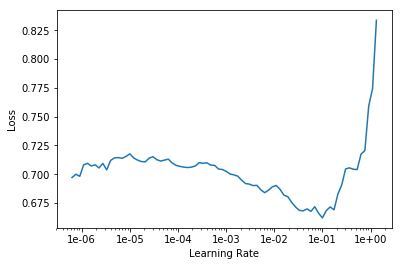

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.604912,0.541534,0.728040


In [41]:
learn.save('first')

In [42]:
learn.load('first');

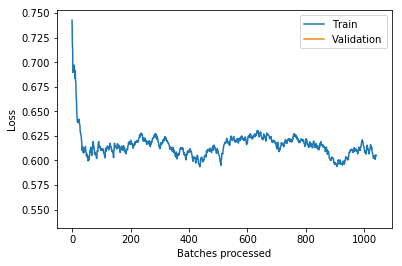

In [43]:
learn.recorder.plot_losses()

In [45]:
%%time

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.463975,0.377466,0.833160


CPU times: user 3min 51s, sys: 42.5 s, total: 4min 33s
Wall time: 4min 32s


In [46]:
learn.save('second')

In [47]:
learn.load('second');

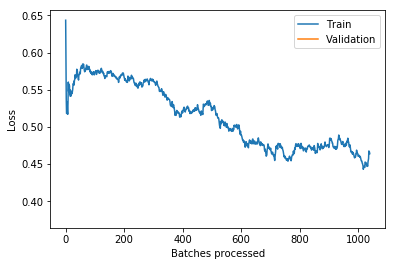

In [48]:
learn.recorder.plot_losses()

In [49]:
%%time

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.383950,0.320826,0.859440


CPU times: user 5min 3s, sys: 56.8 s, total: 5min 59s
Wall time: 5min 58s


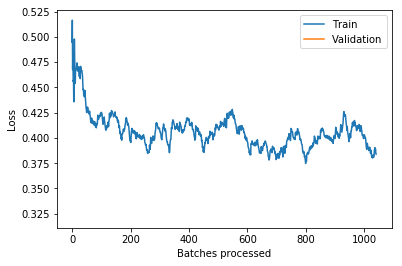

In [50]:
learn.recorder.plot_losses()

In [51]:
learn.save('third')

In [52]:
learn.load('third');

In [53]:
%%time

learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.349296,0.306727,0.867240
2,0.331150,0.299171,0.873480


CPU times: user 12min 6s, sys: 3min 5s, total: 15min 12s
Wall time: 15min 9s


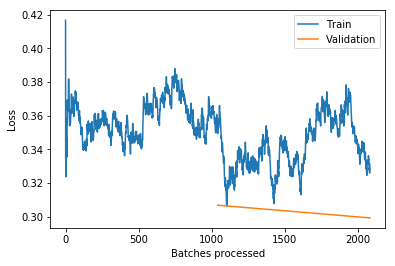

In [54]:
learn.recorder.plot_losses()

In [55]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([6.4010e-04, 9.9936e-01]))